In [1]:
import pandas as pd



In [2]:
df = pd.read_excel('sales.xlsx')

In [3]:
print(df)

            Date        Day               Type  07:00   08:00   09:00  \
0     01/01/2022   Saturday              Sales    0.0  553.50  682.00   
1     01/01/2022   Saturday          Check Qty    0.0   13.00   19.00   
2     01/01/2022   Saturday  Average per Check    0.0   42.58   35.89   
3     01/02/2022     Sunday              Sales   75.0  218.00  554.00   
4     01/02/2022     Sunday          Check Qty    2.0    6.00   18.00   
...          ...        ...                ...    ...     ...     ...   
3271  12/31/2024    Tuesday          Check Qty    1.0    2.00   17.00   
3272  12/31/2024    Tuesday  Average per Check   23.0   75.88   62.12   
3273  01/01/2025  Wednesday              Sales    0.0  408.00  391.50   
3274  01/01/2025  Wednesday          Check Qty    0.0    6.00    6.00   
3275  01/01/2025  Wednesday  Average per Check    0.0   68.00   65.25   

        10:00    11:00    12:00    13:00   14:00  15:00    Total  
0     1463.50  1411.00  1481.50  1367.75  664.50    0.0 

In [4]:
df = df[df['Type'] != 'Check Qty']
df = df[df['Type'] != 'Average per Check']
df = df.drop(columns=['Type'])
df = df.drop(columns=['Total'])

print(df)

            Date        Day   07:00   08:00    09:00    10:00    11:00  \
0     01/01/2022   Saturday    0.00  553.50   682.00  1463.50  1411.00   
3     01/02/2022     Sunday   75.00  218.00   554.00  1640.75  1469.00   
6     01/03/2022     Monday   39.00  146.50   455.50   801.00  1435.00   
9     01/04/2022    Tuesday   39.50  174.00   385.00   710.00   525.00   
12    01/05/2022  Wednesday   54.00    0.00     0.00     0.00    25.50   
...          ...        ...     ...     ...      ...      ...      ...   
3261  12/28/2024   Saturday  143.50  418.50  1234.01  1988.25  1916.25   
3264  12/29/2024     Sunday    0.00  509.75   970.50  1979.25  2031.00   
3267  12/30/2024     Monday  129.75  228.75   784.75  1145.00  1246.00   
3270  12/31/2024    Tuesday   23.00  151.75  1056.00  2026.77  1635.25   
3273  01/01/2025  Wednesday    0.00  408.00   391.50  1559.75  2443.50   

        12:00    13:00   14:00  15:00  
0     1481.50  1367.75  664.50   0.00  
3     1311.25   988.00  113.50 

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df_long = pd.melt(df, id_vars=['Date', 'Day'], 
                  var_name='Time', value_name='Sales')

df_long['timestamp'] = pd.to_datetime(
    df_long['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_long['Time']
)

df_long.sort_values('timestamp', inplace=True)
df_long.reset_index(drop=True, inplace=True)


In [6]:
df_long['hour'] = df_long['timestamp'].dt.hour
df_long['dayofweek'] = df_long['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df_long['month'] = df_long['timestamp'].dt.month
df_long['day'] = df_long['timestamp'].dt.day

# Create lag features (sales from the previous 1 and 2 hours)
df_long['sales_lag_1'] = df_long['Sales'].shift(1)
df_long['sales_lag_2'] = df_long['Sales'].shift(2)

# Drop rows with missing values due to lag features
df_long.dropna(inplace=True)

In [7]:
features = ['hour', 'dayofweek', 'month', 'day', 'sales_lag_1', 'sales_lag_2']
X = df_long[features]
y = df_long['Sales']

# Split the data into training and testing sets while preserving time order.
split_index = int(0.8 * len(df_long))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 67328.99849001481


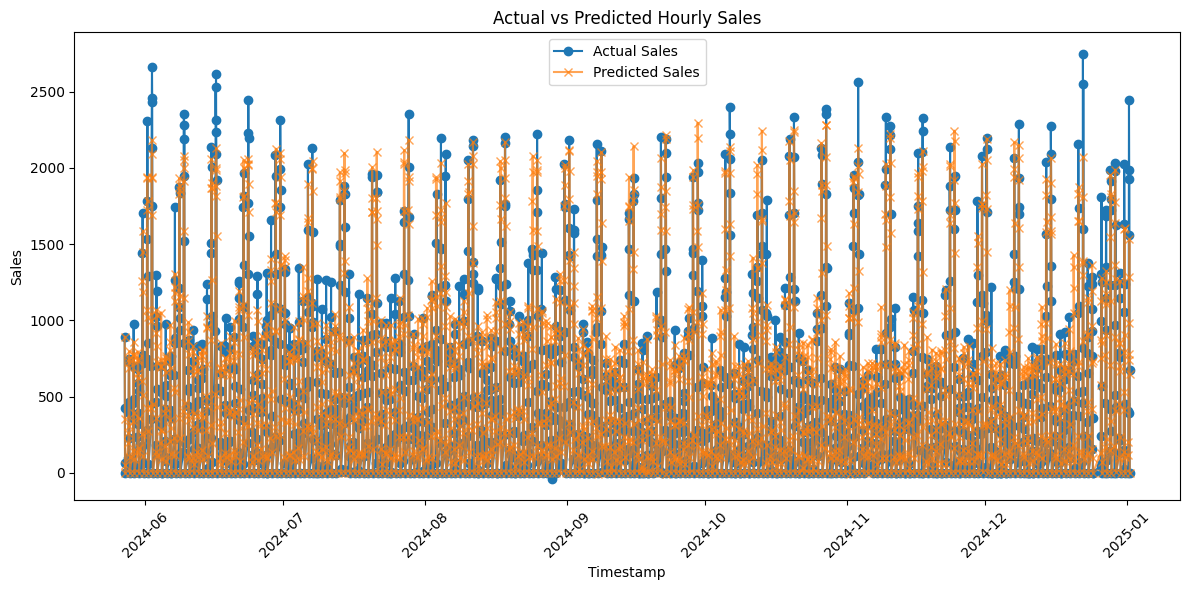

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df_long['timestamp'].iloc[split_index:], y_test, label='Actual Sales', marker='o')
plt.plot(df_long['timestamp'].iloc[split_index:], predictions, label='Predicted Sales', marker='x', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Hourly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
predict_date_str = '2025-02-06'

operating_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15]
sales = []
for i in operating_hours:
    
    predict_hour = i

    # Convert the date string to a datetime object
    predict_date = pd.to_datetime(predict_date_str)

    # Extract the necessary time-based features
    dayofweek = predict_date.dayofweek  # Monday=0, ..., Sunday=6
    month = predict_date.month
    day = predict_date.day

    # For the lag features, you need the sales from the previous hour and two hours ago.
    # In a real scenario, these should come from your historical data.
    # For demonstration, we will use example values.
    if predict_hour == 7:
        
        sales_lag_1 = 0.0  # Sales at 07:00 (or previous available hour)
        sales_lag_2 = 0.0 # Sales at the hour before that
    elif predict_hour == 8:
        sales_lag_1 = predicted_sales
        sales_lag_2 = 0
    else:
        sales_lag_1 = sales[1]
        sales_lag_2 = sales[0]
    # Create a DataFrame for the new observation with the required features
    new_features = pd.DataFrame({
        'hour': [predict_hour],
        'dayofweek': [dayofweek],
        'month': [month],
        'day': [day],
        'sales_lag_1': [sales_lag_1],
        'sales_lag_2': [sales_lag_2]
    })

    # Use the pre-trained model (assumed to be named 'model') to make a prediction
    predicted_sales = model.predict(new_features)
    sales.append(predicted_sales[0])

print("Predicted sales:", sales)

Predicted sales: [np.float64(103.0502), np.float64(248.0627), np.float64(515.4775), np.float64(495.4475), np.float64(433.5905), np.float64(392.53649999999993), np.float64(223.1114), np.float64(56.68), np.float64(0.0)]
